##Codelords-volume calculation

In [ ]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.3/696.3 kB 10.4 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

pothole_dataset_path = '/content/drive/My Drive/pothole_data/'

Mounted at /content/drive


In [ ]:
def preprocess_image(image_path):
    # Step 1: Load the image
    image = cv2.imread(image_path)

    # Step 2: Convert image to HSV format
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Step 3: Create a mask for the green boundary
    lower_green = np.array([35, 100, 100])  # Adjust as needed
    upper_green = np.array([85, 255, 255])  # Adjust as needed
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Step 4: Find contours in the mask
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Assume the largest contour is the boundary
        largest_contour = max(contours, key=cv2.contourArea)

        # Step 5: Create a mask for the inside region
        mask = np.zeros_like(image[:, :, 0])
        cv2.drawContours(mask, [largest_contour], -1, color=255, thickness=cv2.FILLED)

        # Step 6: Extract the region inside the boundary
        segmented_image = cv2.bitwise_and(image, image, mask=mask)

        # Step 7: Crop the image to the bounding box of the contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_segment = segmented_image[y:y+h, x:x+w]

        # Normalize the cropped segment
        cropped_segment_gray = cv2.cvtColor(cropped_segment, cv2.COLOR_BGR2GRAY)
        cropped_segment_normalized = cropped_segment_gray / 255.0

        return cropped_segment_normalized

    # If no contours are found, return None
    return None

In [ ]:
# Step 2: 3D Reconstruction using sample point cloud (this is a placeholder)
# Step 2: Generate a 3D point cloud from the image
def generate_point_cloud(image):
    height, width = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    z = 1 - image  # Invert intensity to simulate depth (lighter = closer)
    points = np.vstack((x.flatten(), y.flatten(), z.flatten())).T
    return points

In [ ]:
# Step 3: Correct the topology (if necessary)
def correct_topology(points):
    # Use PCA to determine the plane and rotate the points accordingly
    pca = PCA(n_components=3)
    pca.fit(points)
    rotated_points = pca.transform(points)

    # Make sure we use only the transformed points without perturbation
    return rotated_points

In [ ]:
# Step 4: Create a convex hull mesh from the point cloud
def create_mesh_from_point_cloud(points):
    if points.shape[0] < 4:
        raise ValueError("Not enough points to create a Convex Hull")
    hull = ConvexHull(points)
    vertices = points
    faces = hull.simplices
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

    # Ensure the mesh is oriented correctly
    if not mesh.is_watertight:
        mesh.fill_holes()
    return mesh

In [ ]:
def calculate_volume(mesh):
    # Assume the surface level is at Z = 0 (ground level)
    surface_level = 0

    # Initialize volume
    total_volume = 0.0

    # Iterate through each triangular face in the mesh
    for face in mesh.faces:
        # Get the vertices of the triangle
        v0 = mesh.vertices[face[0]]
        v1 = mesh.vertices[face[1]]
        v2 = mesh.vertices[face[2]]

        # Calculate the signed volume of the tetrahedron formed by the triangle and the origin
        tetra_volume = np.dot(v0, np.cross(v1, v2)) / 6.0

        # Check if the tetrahedron is below the surface level
        if v0[2] < surface_level and v1[2] < surface_level and v2[2] < surface_level:
            total_volume += tetra_volume
        elif v0[2] < surface_level or v1[2] < surface_level or v2[2] < surface_level:
            # Handle partial intersection with the surface level
            # Adjust the vertices to clip the triangle at the surface level and calculate the volume of the clipped tetrahedron
            # This requires more complex geometry handling

            # For simplicity, we'll only add volume if the entire triangle is below the surface level
            total_volume += tetra_volume

    # Ensure the volume is non-negative and return the absolute value
    return abs(total_volume)



In [ ]:
# Visualization function
def visualize_pothole(image_path, mesh, segmented_image):
    # Load and prepare the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Set up the figure and subplots
    fig = plt.figure(figsize=(18, 6))

    # Display the original image
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(original_image)
    ax1.set_title("Original Image")
    ax1.axis('off')

    # Display the segmented image
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(segmented_image, cmap='gray')
    ax2.set_title("Segmented Image")
    ax2.axis('off')

    # Display the 3D plot of the pothole mesh
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2], triangles=mesh.faces, cmap=plt.cm.viridis)
    ax3.set_title("3D Mesh of Pothole")
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    # Show the plot
    plt.show()

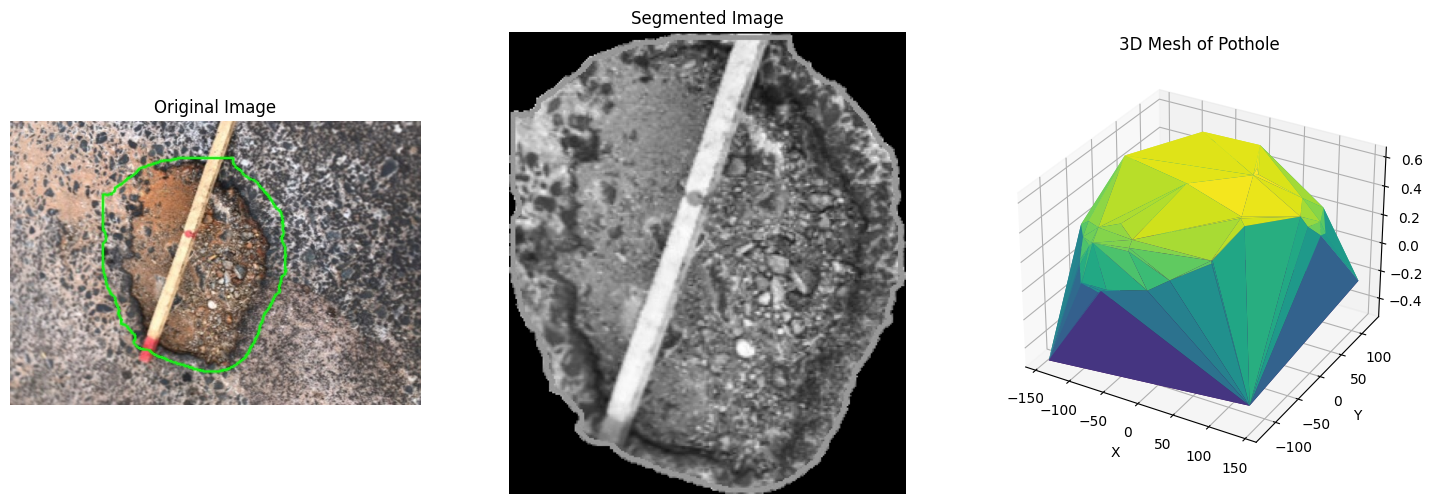

Estimated Pothole Volume: 5849.851295644576 cubic units


In [ ]:
# Main function
def estimate_pothole_volume_and_visualize(image_path):
    processed_image = preprocess_image(image_path)
    point_cloud = generate_point_cloud(processed_image)
    corrected_points = correct_topology(point_cloud)
    mesh = create_mesh_from_point_cloud(corrected_points)
    volume = calculate_volume(mesh)
    visualize_pothole(image_path, mesh,processed_image)
    return volume

# Example usage
image_path = "/train/p116.jpg"
volume = estimate_pothole_volume_and_visualize(pothole_dataset_path+image_path)
print(f"Estimated Pothole Volume: {volume} cubic units")

#Creating a dataset for train images volumes

In [ ]:
import os
import csv

def estimate_pothole_volume(image_path):
    processed_image = preprocess_image(image_path)
    point_cloud = generate_point_cloud(processed_image)
    corrected_points = correct_topology(point_cloud)
    mesh = create_mesh_from_point_cloud(corrected_points)
    volume = calculate_volume(mesh)
    return round(volume, 2)  # Correct volume to 2 decimal places




def process_directory(input_directory, output_directory,output_csv):
    # List all image files in the input directory
    image_files = [f for f in os.listdir(input_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Prepare the CSV file path
    output_csv = os.path.join(output_directory, output_csv)

    # Prepare the CSV file for writing
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Image_Name', 'Volume'])

        # Loop through each image file and calculate the volume
        for image_file in image_files:
            image_path = os.path.join(input_directory, image_file)
            volume = estimate_pothole_volume(image_path)
            writer.writerow([image_file, volume])

    print(f"Processed {len(image_files)} images. Results saved to {output_csv}")

In [ ]:
# Example usage
directory_path = pothole_dataset_path+"/train"  # Replace with your directory path
output_csv = "train_images_volumes.csv"
process_directory(directory_path, pothole_dataset_path, output_csv)

Processed 477 images. Results saved to /content/drive/My Drive/pothole_data/train_images_volumes.csv


#creating dataset for test images volumes


In [ ]:
# Example usage
directory_path = pothole_dataset_path+"/test"  # Replace with your directory path
output_csv = "test_images_volumes.csv"
process_directory(directory_path,pothole_dataset_path, output_csv)

Processed 26 images. Results saved to /content/drive/My Drive/pothole_data/test_images_volumes.csv


#creating a dataset for supplementary image volumes

In [ ]:
# Example usage
directory_path = pothole_dataset_path+"/supplementary"  # Replace with your directory path
output_csv = "supplementary_volumes.csv"
process_directory(directory_path,pothole_dataset_path, output_csv)

Processed 479 images. Results saved to /content/drive/My Drive/pothole_data/supplementary_volumes.csv
